Домашнее задание
по теме «AutoML алгоритмы для работы с данными»

 2. Прогнозирование временных рядов

In [65]:
import warnings
import seaborn as sns
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd # работа с таблицами
import numpy as np # математические вычисления
from scipy import stats # статистические методы
import matplotlib
import matplotlib.pyplot as plt # визуализация данных

from dateutil.parser import parse # парсер даты


from statsmodels.graphics.tsaplots import plot_acf,plot_pacf # plot_acf график автокорреляции, plot_pacf частичной автокорреляции
from statsmodels.graphics.tsaplots import month_plot,quarter_plot # график сезонности данных по месяцам, кварталам
from pandas.plotting import lag_plot # график лага

from statsmodels.tsa.stattools import adfuller # тест Дики-Фуллера

from sklearn.metrics import mean_squared_error # метрика качества MSE
from statsmodels.tools.eval_measures import rmse  # метрика качества Квадратный корень из MSE
from sklearn.model_selection import train_test_split
import pycaret

In [66]:
plt.rcParams["figure.figsize"] = (10,5) # размер графиков

plt.style.use('fivethirtyeight') # стиль графиков

In [67]:
train_df= pd.read_csv(
    "monthly-beer-production-in-austr.csv",
    index_col="Month", parse_dates= True
    )

train_df.head()

,Monthly beer production
Month,
1956-01-01,93.2
1956-02-01,96.0
1956-03-01,95.2
1956-04-01,77.1
1956-05-01,70.9


In [68]:
train_df.dtypes

,0
Monthly beer production,float64


In [69]:
train_df.info(memory_usage=True)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 476 entries, 1956-01-01 to 1995-08-01
Data columns (total 1 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Monthly beer production  476 non-null    float64
dtypes: float64(1)
memory usage: 7.4 KB


In [70]:
# создаем индекс (уникальность) по полю дата
train_df.index= pd.to_datetime(train_df.index)

In [71]:
train_df.index

DatetimeIndex(['1956-01-01', '1956-02-01', '1956-03-01', '1956-04-01',
               '1956-05-01', '1956-06-01', '1956-07-01', '1956-08-01',
               '1956-09-01', '1956-10-01',
               ...
               '1994-11-01', '1994-12-01', '1995-01-01', '1995-02-01',
               '1995-03-01', '1995-04-01', '1995-05-01', '1995-06-01',
               '1995-07-01', '1995-08-01'],
              dtype='datetime64[ns]', name='Month', length=476, freq=None)

Уменишим размер датасета

In [73]:
int_cols = train_df.select_dtypes('int').columns

float_cols = train_df.select_dtypes('float').columns
for col in int_cols:
    train_df[col] = pd.to_numeric(train_df[col], downcast='integer')
for col in float_cols:
    train_df[col] = pd.to_numeric(train_df[col], downcast='float')

In [74]:
train_df.info(memory_usage=True)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 476 entries, 1956-01-01 to 1995-08-01
Data columns (total 1 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Monthly beer production  476 non-null    float32
dtypes: float32(1)
memory usage: 5.6 KB


# EDA

In [ ]:
train_df.describe()

,Monthly beer production
count,476.000000
mean,136.395370
std,33.738731
min,64.800003
25%,112.900000
50%,139.150002
75%,158.824997
max,217.800003


In [ ]:
#Подсчитываем сколько процентов незаполнено столбце
percent_missing = train_df.isnull().sum() * 100 / len(train_df.index)
missing_value_df = pd.DataFrame({'Незаполнено столбце %': percent_missing})

missing_value_df

,Незаполнено столбце %
Monthly beer production,0.0


In [ ]:
#Находим медиану
median_df = pd.DataFrame({'Медиана': train_df.median()})

median_df

,Медиана
Monthly beer production,139.149994


In [ ]:
#Находим дисперсию
var_df = pd.DataFrame({'Диспрерсия': train_df.var()})

var_df

,Диспрерсия
Monthly beer production,1138.302002


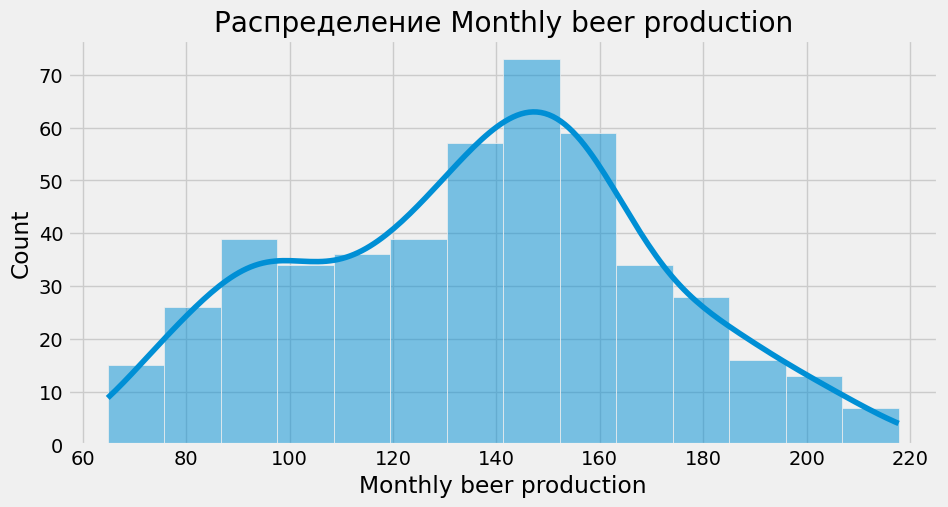

In [ ]:
sns.histplot(train_df['Monthly beer production'], kde=True)
plt.title("Распределение Monthly beer production")
plt.show()

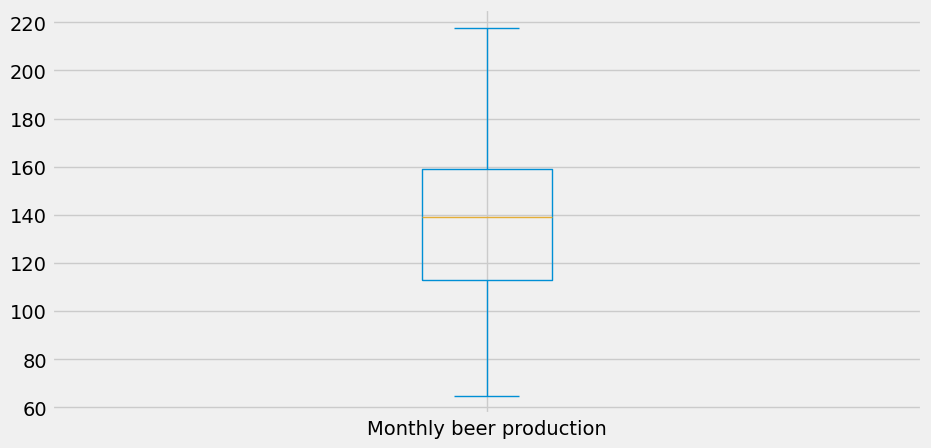

In [ ]:
train_df.plot(
    kind='box',
    subplots=True,
    sharey=False,
)
plt.show()

Нет пропушенных значений в датасете. В данных нет выбросов.

Данные подходят для обучения модели.

<Axes: xlabel='Month'>

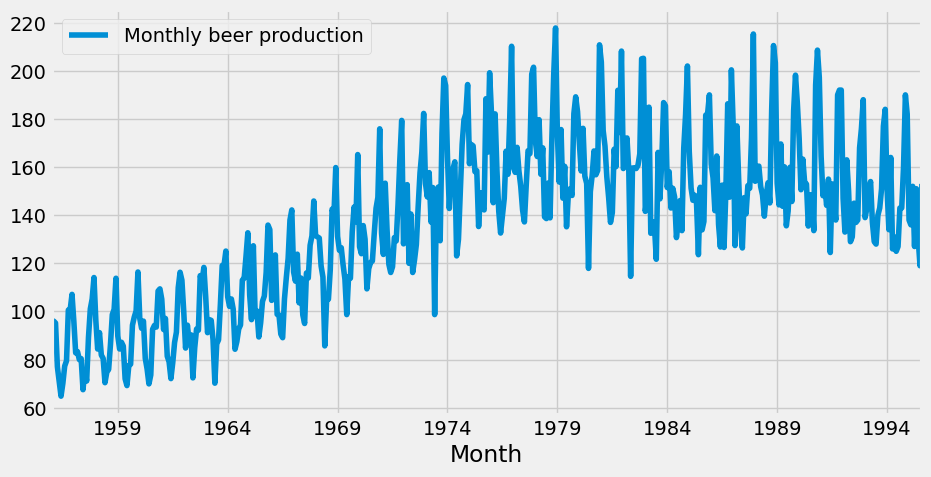

In [ ]:
train_df.plot()

# AutoML

In [75]:
my_random_state = 42

In [76]:
train = train_df[:round(len(train_df)*0.8)].copy()
test= train_df.iloc[round(len(train_df)*0.8):].copy()

In [84]:
from pycaret.time_series import *
s = setup(train, fh = 10, fold = 5, session_id = my_random_state)

,Description,Value
0,session_id,42
1,Target,Monthly beer production
2,Approach,Univariate
3,Exogenous Variables,Not Present
4,Original data shape,"(381, 1)"
5,Transformed data shape,"(381, 1)"
6,Transformed train set shape,"(371, 1)"
7,Transformed test set shape,"(10, 1)"
8,Rows with missing values,0.0%
9,Fold Generator,ExpandingWindowSplitter


In [85]:
best = s.compare_models()

,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2,TT (Sec)
huber_cds_dt,Huber w/ Cond. Deseasonalize & Detrending,1.0985,0.9795,9.6936,11.7618,0.0655,0.0630,0.6438,0.3460
lr_cds_dt,Linear w/ Cond. Deseasonalize & Detrending,1.1376,0.9888,10.0337,11.8703,0.0675,0.0652,0.6405,0.4520
ridge_cds_dt,Ridge w/ Cond. Deseasonalize & Detrending,1.1376,0.9888,10.0337,11.8704,0.0675,0.0652,0.6405,0.5120
en_cds_dt,Elastic Net w/ Cond. Deseasonalize & Detrending,1.1424,0.9939,10.0752,11.9300,0.0679,0.0655,0.6368,0.3340
lasso_cds_dt,Lasso w/ Cond. Deseasonalize & Detrending,1.1456,0.9978,10.1032,11.9763,0.0682,0.0657,0.6340,0.3180
llar_cds_dt,Lasso Least Angular Regressor w/ Cond. Deseasonalize & Detrending,1.1456,0.9978,10.1031,11.9763,0.0682,0.0657,0.6340,0.3700
br_cds_dt,Bayesian Ridge w/ Cond. Deseasonalize & Detrending,1.1640,1.0168,10.2626,12.2012,0.0694,0.0667,0.6195,0.3860
auto_arima,Auto ARIMA,1.1738,1.0075,10.3515,12.0906,0.0681,0.0665,0.5996,184.5740
theta,Theta Forecaster,1.2211,1.1307,10.7692,13.5813,0.0723,0.0692,0.4910,0.0480
exp_smooth,Exponential Smoothing,1.2630,1.0973,11.1691,13.1960,0.0733,0.0718,0.5266,1.1740


Processing:   0%|          | 0/117 [00:00<?, ?it/s]

Лучшая модель для прогнозирования:

In [86]:
best

BaseCdsDtForecaster(fe_target_rr=[WindowSummarizer(lag_feature={'lag': [12, 11,
                                                                        10, 9,
                                                                        8, 7, 6,
                                                                        5, 4, 3,
                                                                        2, 1]},
                                                   n_jobs=1)],
                    regressor=HuberRegressor(), sp=12, window_length=12)

In [87]:
s.plot_model(best, plot = 'forecast', data_kwargs = {'fh' : 24})

Подберем лучшие гиперпараметры

In [88]:
tuned = tune_model(best) # настройка гиперпараметров

,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,1982-09,1.8515,1.6249,15.6416,18.7347,0.1079,0.1003,0.5864
1,1983-07,0.9045,0.8892,8.0096,10.7450,0.0511,0.0491,0.4713
2,1984-05,0.6865,0.7249,6.2113,8.9316,0.0410,0.0402,0.8316
3,1985-03,0.5117,0.5266,4.6523,6.4840,0.0313,0.0312,0.9086
4,1986-01,1.3748,1.2536,12.4328,15.3303,0.0826,0.0803,0.1899
Mean,NaT,1.0658,1.0038,9.3895,12.0451,0.0628,0.0602,0.5976
SD,NaT,0.4878,0.3916,4.0693,4.4239,0.0284,0.0260,0.2584


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   16.5s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   18.5s finished


In [96]:
tuned

BaseCdsDtForecaster(degree=2, deseasonal_model='multiplicative',
                    fe_target_rr=[WindowSummarizer(lag_feature={'lag': [12, 11,
                                                                        10, 9,
                                                                        8, 7, 6,
                                                                        5, 4, 3,
                                                                        2, 1]},
                                                   n_jobs=1)],
                    regressor=HuberRegressor(alpha=0.30461376924290934, epsilon=1.1953442280127677),
                    sp=24, window_length=23)

In [90]:
s.plot_model(tuned, plot = 'forecast', data_kwargs = {'fh' : 24})

In [91]:
len(test)

95

Спрогнозируем 95 шагов вперед, так как это длина наших данных для теста.

In [92]:
forecast = predict_model(tuned, fh = 95)

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50,
  51,
  52,
  53,
  54,
  55,
  56,
  57,
  58,
  59,
  60,
  61,
  62,
  63,
  64,
  65,
  66,
  67,
  68,
  69,
  70,
  71,
  72,
  73,
  74,
  75,
  76,
  77,
  78,
  79,
  80,
  81,
  82,
  83,
  84,
  85,
  86,
  87,
  88,
  89,
  90,
  91,
  92,
  93,
  94,
  95,
  96,
  97,
  98,
  99,
  100,
  101,
  102,
  103,
  104],
 [Text(0, 0, '1986-12'),
  Text(1, 0, '1987-01'),
  Text(2, 0, '1987-02'),
  Text(3, 0, '1987-03'),
  Text(4, 0, '1987-04'),
  Text(5, 0, '1987-05'),
  Text(6, 0, '1987-06'),
  Text(7, 0, '1987-07'),
  Text(8, 0, '1987-08'),
  Text(9, 0, '1987-09'),
  Text(10, 0, '1987-10'),
  Text(11, 0, '1987-11'),
  Text(12, 0, '1987-12'),
  Text(13, 0, '1988-01'),
  Text(14, 0, '1988-

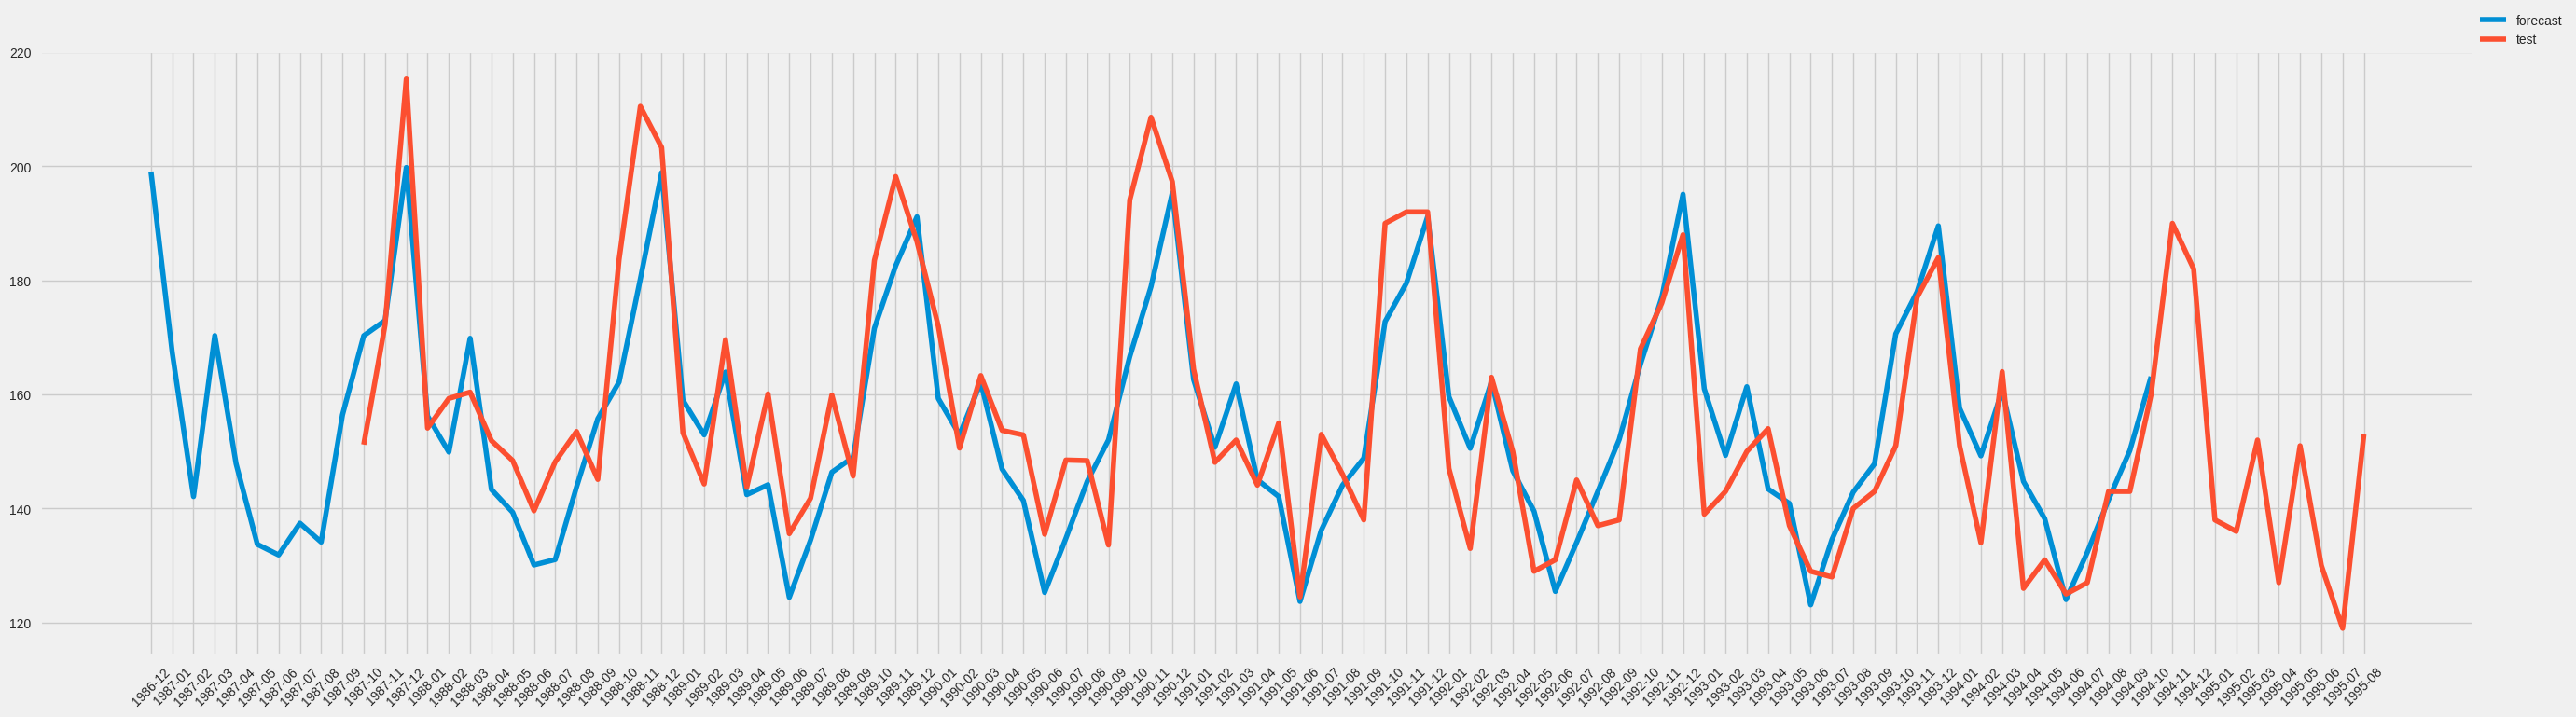

In [93]:
plt.figure(figsize=[30, 8])
plt.plot(forecast.index.strftime('%Y-%m'), forecast['y_pred'].astype(float),label = 'forecast')
plt.plot(test.index.strftime('%Y-%m'),test['Monthly beer production'].astype(float),label = 'test')
plt.legend(loc=[1,1])
plt.xticks(rotation=45)

In [98]:
from sklearn.metrics import mean_squared_error, root_mean_squared_error
from sklearn.metrics import mean_absolute_error, r2_score

err_dict = {}

err_dict['AutoMl'] = {'Mean Absolute Error' : mean_absolute_error(test,forecast),
                      'Mean Squared Error' : mean_squared_error(test,forecast),
                      'Root Mean Squared Error' : root_mean_squared_error(test,forecast),
                      'r2' : r2_score(test,forecast),}
err_dict

{'AutoMl': {'Mean Absolute Error': 20.894388645918998,
  'Mean Squared Error': 647.3633798715604,
  'Root Mean Squared Error': 25.443336649731307,
  'r2': -0.3373235730368995}}

In [99]:
finalModel = finalize_model(tuned)
save_model(finalModel, 'bestModel')

Transformation Pipeline and Model Successfully Saved


(ForecastingPipeline(steps=[('forecaster',
                             TransformedTargetForecaster(steps=[('model',
                                                                 ForecastingPipeline(steps=[('forecaster',
                                                                                             TransformedTargetForecaster(steps=[('model',
                                                                                                                                 BaseCdsDtForecaster(degree=2,
                                                                                                                                                     deseasonal_model='multiplicative',
                                                                                                                                                     fe_target_rr=[WindowSummarizer(lag_feature={'lag': [12,
                                                                                          

Для сравнения обучим HuberRegressor без AutoML

# HuberRegressor

In [102]:
from sklearn.linear_model import HuberRegressor

df = train.copy()
df['lag_1'] = train['Monthly beer production'].shift(1)
df['lag_2'] = train['Monthly beer production'].shift(2)
df.dropna(inplace=True)

X = df[['lag_1', 'lag_2']]
y = df['Monthly beer production']

model = HuberRegressor ()
model.fit(X, y)

y_pred = model.predict(X)

In [103]:
len(y_pred)

379

In [58]:
len(test)

95

Возьмем первые 95 предсказанных значений, так как это длина наших данных для теста.

In [104]:
y_pred_series = pd.Series(y_pred[:95], index=test.loc[:, ['Monthly beer production']].index)
y_pred_series

,0
Month,
1987-10-01,99.360229
1987-11-01,99.152391
1987-12-01,85.532007
1988-01-01,78.388314
1988-02-01,72.973583
...,...
1995-04-01,92.607169
1995-05-01,103.740404
1995-06-01,117.935796


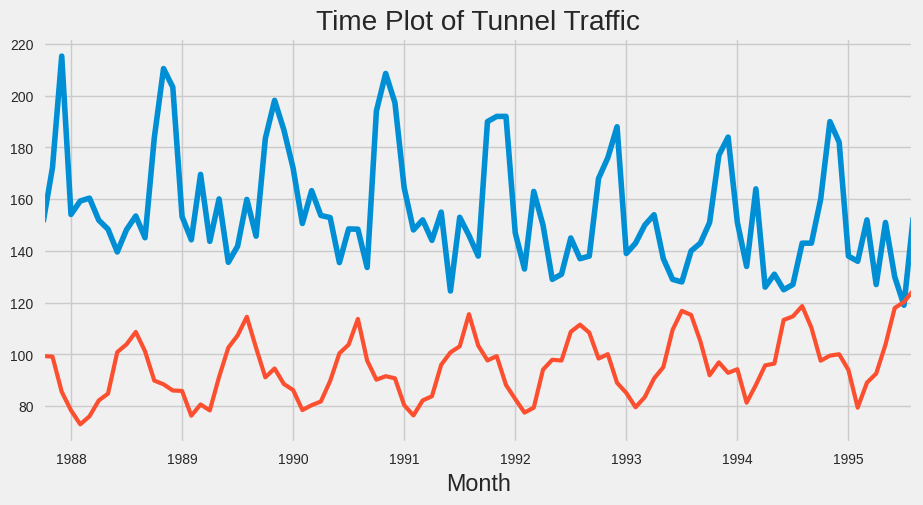

In [ ]:
ax = test.loc[:, 'Monthly beer production'].plot()
ax = y_pred_series.plot(ax=ax, linewidth=3)
ax.set_title('Time Plot of Tunnel Traffic')

In [106]:
err_dict['HuberRegressor'] = {'Mean Absolute Error' : mean_absolute_error(test["Monthly beer production"],y_pred_series),
                      'Mean Squared Error' : mean_squared_error(test["Monthly beer production"],y_pred_series),
                      'Root Mean Squared Error' : root_mean_squared_error(test["Monthly beer production"],y_pred_series),
                      'r2' : r2_score(test["Monthly beer production"],y_pred_series),}

In [107]:
pd.DataFrame(err_dict)

,AutoMl,HuberRegressor
Mean Absolute Error,20.894389,59.988510
Mean Squared Error,647.363380,4380.127063
Root Mean Squared Error,25.443337,66.182528
r2,-0.337324,-8.048469


HuberRegressor без AutoML показала результаты хуже.